Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name, email and UFID.
Please do not modify instruction cells or any cells with automated tests (marked with `[ASSERTS]`). Note: you can add new cells if you need them, but answers must be in the cells with `YOUR CODE HERE` or "YOUR ANSWER HERE" comments.

---

## Homework 5: CNNs, RNNs, and AutoEncoders

## Preamble: Write your Name, Email and UFID

In [1]:
NAME = 'Trevor Gross'
EMAIL = 'trevorgross@ufl.edu'
UFID = 

# YOUR CODE HERE

print('Homework 5 -- name: {}, email: {}, UFID: {}\n'.format(NAME, EMAIL, UFID))

Homework 5 -- name: Trevor Gross, email: trevorgross@ufl.edu, UFID: 



In [2]:
""" [ASSERTS] Check that your name, email, and UFID is filled in."""
assert NAME != '' and NAME != 'Your name here.' and len(NAME) > 3
assert EMAIL != '' and EMAIL != 'Your email here.' and len(EMAIL) > 7
assert type(UFID) == int and UFID != 12345678 and UFID >= 10000000 and UFID <= 99999999

## Academic Integrity

### <span style="color:red;">This is an individual assignment. Academic integrity violations (i.e., cheating, plagiarism) will be reported to SCCR!</span><br/>
#### The official CISE policy recommended for such offenses is a course grade of E. Additional sanctions may be imposed by SCCR such as marks on your permanent educational transcripts, dismissal or expulsion.
#### Reminder of the Honor Pledge: On all work submitted for credit by Students at the University of Florida, the following pledge is either required or implied: *"On my honor, I have neither given nor received unauthorized aid in doing this assignment."*

#### Acknowledgement: Do you acknowledge and understand the academic integrity warning above? 

In [3]:
academic_integrity_acknowledgement = True
# YOUR CODE HERE

In [4]:
""" [ASSERTS] Check that you acknowledge the academic integrity warning, you understand it and have been reminded of the UF Honor Pledge."""
assert academic_integrity_acknowledgement

#### The following cell's code (import statements etc.) is provided for you and you should not need to change it.

In [5]:
# Load packages we need
import sys
import os
import time

import numpy as np
import pandas as pd
import sklearn

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.datasets import fashion_mnist, cifar10, imdb

from sklearn.model_selection import train_test_split

# import layers and callbacks we may use (may not be a complete list)
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.models import Model, Sequential

from tensorflow.python.keras.utils import layer_utils


from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 14})

# Load the TensorBoard notebook extension
#%load_ext tensorboard


# Let's check our software versions
print('------------')
print('### Python version: ' + __import__('sys').version)
print('### NumPy version: ' + np.__version__)
print('### Scikit-learn version: ' + sklearn.__version__)
print('### Tensorflow version: ' + tf.__version__)
print('------------')

def var_exists(var_name):
    return (var_name in globals() or var_name in locals())

2024-04-08 22:49:58.153434: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


------------
### Python version: 3.10.13 (main, Sep 11 2023, 13:21:10) [GCC 11.2.0]
### NumPy version: 1.26.3
### Scikit-learn version: 1.3.0
### Tensorflow version: 2.11.0
------------


#### This is the seed we will use, do not change it.

In [6]:
# set the seed
seed = 42
np.random.seed(seed)

prop_vec = [16, 2, 2] # proportions for train - val - test splits

epsf = 1e-9 # small epsilon value for floating point comparisons

In [7]:
""" [ASSERTS] Check seed. """
assert seed == 42

In [8]:
"""
## Plots a set of images (all m x m)
## input is  a square number of images, i.e., np.array with shape (z*z, dim_x, dim_y) for some integer z > 1
"""
def plot_images(im, dim_x=28, dim_y=28, one_row=False, out_fp='out.png', save=False, show=True, cmap='gray', fig_size=(14,14), titles=None, titles_fontsize=12):
    fig = plt.figure(figsize=fig_size)
    im = im.reshape((-1, dim_x, dim_y))

    num = im.shape[0]
    assert num <= 3 or np.sqrt(num)**2 == num or one_row, 'Number of images is too large or not a perfect square!'
    
    if titles is not None:
        assert num == len(titles)
    
    if num <= 3:
        for i in range(0, num):
            plt.subplot(1, num, 1 + i)
            plt.axis('off')
            if type(cmap) == list:
                assert len(cmap) == num
                plt.imshow(im[i], cmap=cmap[i]) # plot raw pixel data
            else:
                plt.imshow(im[i], cmap=cmap) # plot raw pixel data
            if titles is not None:
                plt.title(titles[i], fontsize=titles_fontsize)
    else:
        sq = int(np.sqrt(num))
        for i in range(0, num):
            if one_row:
                plt.subplot(1, num, 1 + i)
            else:
                plt.subplot(sq, sq, 1 + i)
            plt.axis('off')
            if type(cmap) == list:
                assert len(cmap) == num
                plt.imshow(im[i], cmap=cmap[i]) # plot raw pixel data
            else:
                plt.imshow(im[i], cmap=cmap) # plot raw pixel data
            if titles is not None:
                plt.title(titles[i], fontsize=titles_fontsize)

    if save:
        plt.savefig(out_fp)

    if show:
        plt.show()
    else:
        plt.close()

### Loading CIFAR-10 data.

In [9]:
# refer to: https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data
# and to https://www.cs.toronto.edu/~kriz/cifar.html
def load_preprocess_cifar10(onehot=True, minmax_normalize=True):
    labels = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
    train, testval = cifar10.load_data()
    
    train_x, train_y = train
    testval_x, testval_y = testval
    
    if minmax_normalize:
        train_x = train_x / 255.0
        testval_x = testval_x / 255.0
        
    if onehot:
        train_y = keras.utils.to_categorical(train_y, labels.shape[0])
        testval_y = keras.utils.to_categorical(testval_y, labels.shape[0])
    
    # split test - val
    nval = testval_x.shape[0] // 2
    
    val_x = testval_x[:nval]
    val_y = testval_y[:nval]
    
    test_x = testval_x[nval:]
    test_y = testval_y[nval:]
    
    return train_x, train_y, test_x, test_y, val_x, val_y, labels

In [10]:
# do some sanity checks
train_x, train_y, test_x, test_y, val_x, val_y, labels = load_preprocess_cifar10(onehot=False, minmax_normalize=False)
assert train_x.shape[0] == train_y.shape[0] and test_x.shape[0] == test_y.shape[0] and val_x.shape[0] == val_y.shape[0]
assert np.amax(train_x) >= 255 and np.amax(test_x) >= 255 and np.amax(val_x) >= 255
assert train_y.shape == (train_y.shape[0],) or train_y.shape == (train_y.shape[0],1)

train_x, train_y, test_x, test_y, val_x, val_y, labels = load_preprocess_cifar10(onehot=True, minmax_normalize=False)
assert np.amax(train_x) >= 255 and np.amax(test_x) >= 255 and np.amax(val_x) >= 255
assert train_y.shape == (train_y.shape[0],10) and train_y.shape[1] == test_y.shape[1]


# actually load the data
train_x, train_y, test_x, test_y, val_x, val_y, labels = load_preprocess_cifar10()
assert np.amax(train_x) <= 1 and np.amax(test_x) <= 1 and np.amax(val_x) <= 1
assert np.amax(train_x) >= 0 and np.amax(test_x) >= 0 and np.amax(val_x) >= 0

assert labels.shape[0] == 10 and labels.shape[0] == train_y.shape[1]

print(train_x.shape, val_x.shape, test_x.shape, train_y.shape)

(50000, 32, 32, 3) (5000, 32, 32, 3) (5000, 32, 32, 3) (50000, 10)


---
# [Task 1] (25 points) Training a CNN For CIFAR-10

#### We will use the following architecture
- Conv layer with 32 filters, (3,3) filter size, stride of 1, padding 'same'
- Conv layer with 32 filters, (3,3) filter size, stride of 1, padding 'same'
- Max pooling layer (2,2)
- Conv layer with 64 filters, (3,3) filter size, stride of 1, padding 'same'
- Conv layer with 64 filters, (3,3) filter size, stride of 1, padding 'same'
- Max pooling layer (2,2)
- Conv layer with 128 filters, (3,3) filter size, stride of 1, padding 'same'
- Conv layer with 128 filters, (3,3) filter size, stride of 1, padding 'same'
- Max pooling layer (2,2)
- Flatten
- FC with 128 units
- Dropout with rate 25%
- FC with 96 units
- Dropout with rate 25%
- (Output layer) FC with 10 units

#### For all layers (if applicable) except the output layer you should use:
- ReLU as activation function
- LeCun uniform weight initialization strategy
- L2 regularization with regularization constant set to 0.001

#### For the output layer you should select a suitable activation function that is consistent with the task and loss function you use. Use Adam for the optimizer with learning rate 0.002.

### [Task 1a] (15 points) Implement create_compile_cnn()

In [11]:
def create_compile_cnn(input_shape=[32, 32, 3], num_outputs=10, verbose=False):
    
    model = keras.models.Sequential(name='CIFAR-10--CNN')
    
    ### Don't forget to compile the model and print the summary if verbose=True
    """Fill in your code in the function (~20 lines)
    """
    # YOUR CODE HERE
    hidden_widths = [32, 64, 128]
    fc_widths = [128, 96]

    for i, hw in enumerate(hidden_widths):
        if i == 0:
            model.add(Conv2D(hw, kernel_size=(3,3), input_shape=input_shape, activation='relu', kernel_initializer=tf.keras.initializers.LecunUniform(seed=seed), bias_initializer=tf.keras.initializers.LecunUniform(seed=seed), activity_regularizer=tf.keras.regularizers.L2(l2=0.001), padding='same', name='conv{}a'.format(i)))
        else:
            model.add(Conv2D(hw, kernel_size=(3,3), activation='relu', kernel_initializer=tf.keras.initializers.LecunUniform(seed=seed), bias_initializer=tf.keras.initializers.LecunUniform(seed=seed), activity_regularizer=tf.keras.regularizers.L2(l2=0.001), padding='same', name='conv{}a'.format(i)))
        model.add(Conv2D(hw, kernel_size=(3,3), activation='relu', kernel_initializer=tf.keras.initializers.LecunUniform(seed=seed), bias_initializer=tf.keras.initializers.LecunUniform(seed=seed), activity_regularizer=tf.keras.regularizers.L2(l2=0.001), padding='same', name='conv{}b'.format(i)))
        model.add(MaxPooling2D(2, name='maxpool{}'.format(i)))

    model.add(Flatten(name='flatten'))

    for i, fw in enumerate(fc_widths):
        model.add(Dense(fw, activation='relu', kernel_initializer=tf.keras.initializers.LecunUniform(seed=seed), bias_initializer=tf.keras.initializers.LecunUniform(seed=seed), activity_regularizer=tf.keras.regularizers.L2(l2=0.001), name='fc{}'.format(i)))
        model.add(Dropout(.25, name='dropout{}'.format(i)))

    model.add(Dense(num_outputs, activation="softmax", name='output'))

    opt = keras.optimizers.Adam(learning_rate=.002)

    if verbose:
        model.summary()

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [12]:
_ = create_compile_cnn(verbose=True)

2024-04-08 22:50:06.862597: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-08 22:50:06.871415: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "CIFAR-10--CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv0a (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv0b (Conv2D)             (None, 32, 32, 32)        9248      
                                                                 
 maxpool0 (MaxPooling2D)     (None, 16, 16, 32)        0         
                                                                 
 conv1a (Conv2D)             (None, 16, 16, 64)        18496     
                                                                 
 conv1b (Conv2D)             (None, 16, 16, 64)        36928     
                                                                 
 maxpool1 (MaxPooling2D)     (None, 8, 8, 64)          0         
                                                                 
 conv2a (Conv2D)             (None, 8, 8, 128)       

### [Task 1b] (10 points) Train the model. Fill in the implementation below. 
#### Note: make sure to delete the model file on disk if incorrect, or else the assertions passing may not reflect a correct implementation (loading the model if it exists is there to save time and not retrain the model each time if the implementation does not change).

In [13]:
cnn_model_fp = './cifar10-cnn.tf'

# If the model file exists, load it. Otherwise train it and save the model.
# Note: if you need to retrain the model, simply delete the h5 file.
if os.path.exists(cnn_model_fp):
    model = keras.models.load_model(cnn_model_fp)
else:
    model = create_compile_cnn(verbose=False)
    
    # do the training using model.fit() for at least 5 epochs and your chosen batch_size
    # (make sure your network is actually learning...)
    # you can set any callback you want on it, including checkpoint, early stopping, etc.
    """Fill in your code here (~3-5 lines)
    """
    # YOUR CODE HERE
    early_stop_cb = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    
    max_epochs = 5
    batch_size = 64

    history = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=max_epochs, batch_size=batch_size, callbacks=[early_stop_cb])
    
    
    # save the model
    model.save(cnn_model_fp)

In [14]:
""" [ASSERTS] Check 1a and 1b completed. """

# let's evaluate the model on the test data
loss, acc = model.evaluate(test_x, test_y, verbose=0)
print('[Model] Test accuracy: {:.2f}%'.format(100*acc))

assert var_exists('model')

model = create_compile_cnn(verbose=False) # recreate the model object in case the version on disk is no good

trainable_count = layer_utils.count_params(model.trainable_weights)
assert trainable_count > 500000 and trainable_count < 600000

assert len(model.layers) == 15
assert model.layers[0].filters == 32 and model.layers[0].groups == 1


[Model] Test accuracy: 62.92%


---
# [Task 2] (25 points) Processing Sequence Data with RNNs for Sentiment Analysis

## We will use the imdb dataset for this task. The dataset consists of reviews from IMDB. We will use it for sentiment analysis.

## [Task 2a] (10 points) Fill in the implementation of load_preprocess_imdb()

In [15]:
# refer to: https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb
def load_preprocess_imdb(num_words=10000, train_prop=0.8, val_prop=0.5, maxlen=100, vectorize=False):

    train, testval = imdb.load_data(num_words=num_words, maxlen=maxlen, oov_char=0)
    
    ### Process the data 
    ### Merge train and testval ('all_x', 'all_y')
    ### then you must encode the features of each examples as a sequence of size maxlen (represented as a np.array). You can use np.pad to pad the sequence. 
    ### Make sure to pad sequences with 0 as appropriate.
    """Fill in your code here (~5-10 lines)
    """
    # YOUR CODE HERE
    train_testval = train + testval
    (train_x, train_y) = train
    (testval_x, testval_y) = testval
    all_x_pre = np.concatenate((train_x, testval_x), axis=None)
    all_y = np.concatenate((train_y, testval_y))
    all_x = np.zeros((18994, maxlen))

    for i in range(len(all_x_pre)):
        all_x[i] += np.pad(np.asarray(all_x_pre[i]), (0, maxlen-len(all_x_pre[i])))

    # split the data into train, test, val
    # do the split
    train_x, testval_x, train_y, testval_y = train_test_split(all_x, all_y, test_size=1-train_prop, random_state=seed)
    val_x, test_x, val_y, test_y = train_test_split(testval_x, testval_y, test_size=1-val_prop, random_state=seed)
    
    return train_x, train_y, test_x, test_y, val_x, val_y

In [16]:
# the size of the vocabulary we'll use
vocab_size = 12000
maxlen = 150

# sanity checks
train_x, train_y, test_x, test_y, val_x, val_y = load_preprocess_imdb(num_words=vocab_size, maxlen=maxlen)
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape, val_x.shape, val_y.shape)

(15195, 150) (15195,) (1900, 150) (1900,) (1899, 150) (1899,)


In [17]:
""" [ASSERTS] Check 2a completed. """

assert var_exists('train_x') and var_exists('train_y')
assert train_x.shape == (15195, maxlen) and train_y.shape == (train_x.shape[0],)


### [Task 2b] (15 points) Complete the code below to define an RNN architecture for sentiment analysis. The goal is to predict the sentiment of IMDB reviews.

### Use the following architecture. For whatever is not specified (loss function, metrics, return sequences, optimizer, learning rate, etc.) you should complete it as appropriate.
- Embedding layer of size 'embedding_size'
- GRU layer with 64 units
- GRU layer with 64 units and dropout rate 20%
- Dense layer with num_outputs units

### With this architecture correctly implemented you should have about 2.4m parameters and it should be easy to achieve 88%+ test accuracy.

In [18]:
def create_compile_rnn(input_shape=[None], vocab_size=vocab_size, embedding_size=196, num_outputs=1, verbose=False):
    
    model = keras.models.Sequential(name='imdb-RNN')
    
    ### Don't forget to compile the model and print the summary if verbose=True
    """Fill in your code here (~5-10 lines)
    """
    # YOUR CODE HERE
    model.add(keras.layers.Embedding(input_shape=input_shape, input_dim=vocab_size, output_dim=embedding_size, name='embedding'))
    model.add(keras.layers.GRU(64, activation='tanh', return_sequences=True, name='gru1'))
    model.add(keras.layers.GRU(64, activation='tanh', dropout=.2, name='gru2'))
    model.add(Dense(num_outputs, activation='sigmoid', name='output'))

    initial_learning_rate = 0.01
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=1000,
        decay_rate=0.9,
        staircase=True)

    opt = keras.optimizers.Adam(learning_rate=lr_schedule)

    if verbose:
        model.summary()

    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [19]:
model = create_compile_rnn(verbose=True)

Model: "imdb-RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 196)         2352000   
                                                                 
 gru1 (GRU)                  (None, None, 64)          50304     
                                                                 
 gru2 (GRU)                  (None, 64)                24960     
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 2,427,329
Trainable params: 2,427,329
Non-trainable params: 0
_________________________________________________________________


In [20]:
early_stop_cb = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# feel free to tweak the batch size, number of epochs and callbacks.
max_epochs = 5
batch_size = 128

"""Fill in your code here (~1-2 lines)
"""
# YOUR CODE HERE
model = create_compile_rnn(verbose=False)

hist = model.fit(train_x, train_y, epochs=max_epochs, batch_size=batch_size, validation_data=(val_x, val_y), callbacks=[early_stop_cb])

Epoch 1/5
119/119 [==============================] - 85s 643ms/step - loss: 0.6339 - accuracy: 0.5814 - val_loss: 0.3849 - val_accuracy: 0.8299
Epoch 2/5
119/119 [==============================] - 70s 591ms/step - loss: 0.2540 - accuracy: 0.8990 - val_loss: 0.3016 - val_accuracy: 0.8778
Epoch 3/5
119/119 [==============================] - 72s 604ms/step - loss: 0.1187 - accuracy: 0.9583 - val_loss: 0.3412 - val_accuracy: 0.8836
Epoch 4/5
119/119 [==============================] - 75s 629ms/step - loss: 0.0655 - accuracy: 0.9779 - val_loss: 0.4079 - val_accuracy: 0.8815
Epoch 5/5
119/119 [==============================] - 70s 588ms/step - loss: 0.0409 - accuracy: 0.9860 - val_loss: 0.5037 - val_accuracy: 0.8668


In [21]:
""" [ASSERTS] Check 2b completed. """

assert var_exists('model') and var_exists('hist')
val_acc = hist.history['val_accuracy']
assert np.amax(val_acc) >= 0.875

# let's evaluate the model on the test data
loss, acc = model.evaluate(test_x, test_y, verbose=0)
print('[Model] Test accuracy: {:.2f}%'.format(100*acc))


[Model] Test accuracy: 87.79%


---
# [Task 3] (25 points) Sentiment Analysis with Multi-Head Attention

## In this task the objective is to use multi-head attention (layers.MultiHeadAttention) to match or exceed the performance of the RNN trained in Task 2.
## You can use whatever architecture you want as long as it includes at least one MultiHeadAttention layer (with at least two heads). Ideally we also don't want it to be an RNN.
## The catch is we want to do it using much fewer total parameters.
## For example, we will aim to use less than 500k trainable parameters while still achieving 88%+ test/val accuracy.
## You will also need to ensure the total training time is less than 10 minutes.

## Hints: 
- you may find it useful to use the Function API of Keras.
- a possible approach is to use an embedding layer appropriately connected to the MultiHeadAttention, but note that if the embedding layer cannot be too large or it will use up too many parameters. 
- you may also find it useful to use dropout.

In [22]:
def create_compile_attention(input_shape=(150,), vocab_size=vocab_size, num_outputs=1, verbose=False):
    
    ### Don't forget to compile the model and print the summary if verbose=True
    """Fill in your code here (~10-15 lines). Set the name of your model to be imdb-Attention'
    """
    # YOUR CODE HERE
    name = 'imdb-Attention'
    
    inputs = keras.layers.Input(shape=input_shape, name='input')
    embedding_layer = keras.layers.Embedding(input_dim=vocab_size, output_dim=32, name='embedding')(inputs)

    attention_output = keras.layers.MultiHeadAttention(num_heads=2, key_dim=16, name='mha')(embedding_layer, embedding_layer)
    norm_layer = keras.layers.LayerNormalization(epsilon=1e-6, name='layernorm')(attention_output)
    dropout_layer_1 = keras.layers.Dropout(0.1, name='dropout1')(norm_layer)
    
    ff_layer = keras.layers.Dense(16, activation='relu', name='feedforward')(dropout_layer_1)
    dropout_layer_2 = keras.layers.Dropout(0.1, name='dropout2')(ff_layer)
    
    flatten_layer = keras.layers.Flatten()(dropout_layer_2)
    outputs = keras.layers.Dense(num_outputs, activation='sigmoid', name='output')(flatten_layer)

    model = keras.Model(inputs=inputs, outputs=outputs, name=name)

    opt = keras.optimizers.Adam(learning_rate=0.001)

    if verbose:
        model.summary()

    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [23]:
model = create_compile_attention(verbose=True)

Model: "imdb-Attention"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 150)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 150, 32)      384000      ['input[0][0]']                  
                                                                                                  
 mha (MultiHeadAttention)       (None, 150, 32)      4224        ['embedding[0][0]',              
                                                                  'embedding[0][0]']              
                                                                                                  
 layernorm (LayerNormalization)  (None, 150, 32)     64          ['mha[0][0]']       

In [24]:
early_stop_cb = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# feel free to tweak the batch size, number of epochs and callbacks.
max_epochs = 5
batch_size = 64

"""Fill in your code here (~1-2 lines)
"""
# YOUR CODE HERE
model = create_compile_attention(verbose=False)

st = time.time()

hist = model.fit(train_x, train_y, epochs=max_epochs, batch_size=batch_size, validation_data=(val_x, val_y), callbacks=[early_stop_cb])

et = time.time()
elapsed_time = et - st
print('Total training time {:.1f} seconds'.format(elapsed_time))

Epoch 1/5
238/238 [==============================] - 20s 80ms/step - loss: 0.5169 - accuracy: 0.6944 - val_loss: 0.2850 - val_accuracy: 0.8852
Epoch 2/5
238/238 [==============================] - 19s 79ms/step - loss: 0.2122 - accuracy: 0.9162 - val_loss: 0.2726 - val_accuracy: 0.8889
Epoch 3/5
238/238 [==============================] - 18s 74ms/step - loss: 0.1373 - accuracy: 0.9498 - val_loss: 0.2885 - val_accuracy: 0.8847
Epoch 4/5
238/238 [==============================] - 20s 83ms/step - loss: 0.0964 - accuracy: 0.9652 - val_loss: 0.4127 - val_accuracy: 0.8547
Epoch 5/5
238/238 [==============================] - 20s 86ms/step - loss: 0.0639 - accuracy: 0.9774 - val_loss: 0.5653 - val_accuracy: 0.8589
Total training time 97.1 seconds


In [25]:
""" [ASSERTS] Check 3 completed. """

assert var_exists('model') and var_exists('hist')
assert model.name == 'imdb-Attention'

val_acc = hist.history['val_accuracy']
assert np.amax(val_acc) >= 0.87 # check that we match the RNN performance

# check number of parameters 
trainable_count = layer_utils.count_params(model.trainable_weights)
assert trainable_count <= 500000

# check total training time
assert elapsed_time <= 600

# let's evaluate the model on the test data
loss, acc = model.evaluate(test_x, test_y, verbose=0)
acc_per_100kparam_score = acc / (trainable_count / (100*1000))
print('[Model] Test accuracy: {:.2f}% [score: {:.2f}]'.format(100*acc, 100*acc_per_100kparam_score))


[Model] Test accuracy: 89.74% [score: 22.94]


### How high of a score did you achieve? (It is possible to match the RNN performance and easily achieve scores above 100.)

In [26]:
# I received a score of 22.87, with a 89.47% test accuracy and just under 400k parameters.

---
# [Task 4] (25 points) AutoEncoders

### We will use Fashion-MNIST for this.

In [27]:
"""
## Load and preprocess the Fashion-MNIST dataset
"""
def load_preprocess_fmnist_data(flatten=True, onehot=True, minmax_normalize=True, val_prop=0.5, seed=None, verbose=False):
    
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    
    assert x_train.shape == (60000, 28, 28) and x_test.shape == (10000, 28, 28)
    assert y_train.shape == (60000,) and y_test.shape == (10000,)

    if minmax_normalize:
        x_train = x_train / 255.0
        x_test = x_test / 255.0

    if verbose: 
        print('Loaded Fashion-MNIST data; shape: {} [y: {}], test shape: {} [y: {}]'.format(x_train.shape, y_train.shape,
                                                                                      x_test.shape, y_test.shape))
    
    if flatten: # Let's flatten the images for easier processing (labels don't change)
        flat_vec_size = 28*28
        x_train = x_train.reshape(x_train.shape[0], flat_vec_size)
        x_test = x_test.reshape(x_test.shape[0], flat_vec_size)

    if onehot: # Put the labels in "one-hot" encoding using keras' to_categorical()
        num_classes = 10
        y_train = keras.utils.to_categorical(y_train, num_classes)
        y_test = keras.utils.to_categorical(y_test, num_classes)

    train_x = x_train
    train_y = y_train

    # we'll split the test set into test and val
    testval_x = x_test
    testval_y = y_test

    # do the split
    val_x, test_x, val_y, test_y = train_test_split(testval_x, testval_y, test_size=val_prop, random_state=seed)
    
    return train_x, train_y, test_x, test_y, val_x, val_y


# grab the data
train_x, train_y, test_x, test_y, val_x, val_y = load_preprocess_fmnist_data(flatten=False, onehot=False, val_prop=0.5, seed=seed) 

# sanity check shapes
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape, val_x.shape, val_y.shape)

assert train_x.shape == (60000, 28, 28) and train_y.shape == (60000,) and test_x.shape == (5000, 28, 28) and test_y.shape == (5000,)

(60000, 28, 28) (60000,) (5000, 28, 28) (5000,) (5000, 28, 28) (5000,)


### [Task 4a] (15 points) Complete the implementation of create_simple_ae() according to the architecture and instructions below.

#### Start by creating the encoder ('enc_model'). It should have the following architecture:
- Flatten
- FC with hidden_widths[0] units with activation ReLU
- FC with hidden_widths[1] units with activation ReLU
- Dropout with rate 'dropout_rate'
- FC with latent_width units with activation *sigmoid*

#### Then create the decoder ('dec_model'). It should have the following architecture:
- (Input has shape latent_width)
- FC with hidden_widths[1] units with activation ReLU
- FC with hidden_widths[0] units with activation ReLU
- Dropout with rate 'dropout_rate'
- FC with 784 units with activation *sigmoid*
- Reshape to input_shape

#### Finally connect the two models together into a new model ('ae_model'). Make sure that the model takes the input that the encoder takes and produces the output that the decoder produces.

In [28]:
def create_simple_ae(input_shape=(28, 28), latent_width=64, hidden_widths=[256, 96], dropout_rate=0.0, verbose=False):
    name = 'AE-simple'

    # encoder
    enc_input = Input(shape=input_shape, name='Encoder-input')
    """Fill in your code here (~3-5 lines)
    """
    # YOUR CODE HERE
    enc_flatten = keras.layers.Flatten(name='enc_flatten')(enc_input)
    enc_fc_1 = keras.layers.Dense(hidden_widths[0], activation='relu', name='enc_fc_1')(enc_flatten)
    enc_fc_2 = keras.layers.Dense(hidden_widths[1], activation='relu', name='enc_fc_2')(enc_fc_1)
    enc_dropout = keras.layers.Dropout(dropout_rate, name='enc_dropout')(enc_fc_2)
    enc_outputs = keras.layers.Dense(latent_width, activation='sigmoid', name='enc_outputs')(enc_dropout)
    enc_model = Model(inputs=[enc_input], outputs=[enc_outputs], name='Encoder')
   
    
    # decoder
    dec_input = Input(shape=[latent_width], name='Decoder-input')
    """Fill in your code here (~3-5 lines)
    """
    # YOUR CODE HERE
    def dec(dec_input):
        dec_fc_1 = keras.layers.Dense(hidden_widths[1], activation='relu', name='dec_fc_1')(dec_input)
        dec_fc_2 = keras.layers.Dense(hidden_widths[0], activation='relu', name='dec_fc_2')(dec_fc_1)
        dec_dropout = keras.layers.Dropout(dropout_rate, name='dec_dropout')(dec_fc_2)
        dec_outputs = keras.layers.Dense(input_shape[0]*input_shape[1], activation='sigmoid', name='dec_outputs')(dec_dropout)
        dec_reshape = keras.layers.Reshape((input_shape), name='dec_reshape')(dec_outputs)
        return dec_reshape
    dec_reshape = dec(dec_input)
    dec_model = Model(inputs=[dec_input], outputs=[dec_reshape], name='Decoder')
    
    # connect the two
    """Fill in your code here (~3-5 lines)
    """
    # YOUR CODE HERE
    ae_dec_reshape = dec(enc_outputs)
    ae_model = Model(inputs=[enc_input], outputs=[ae_dec_reshape], name='AutoEncoder')
    
    opt = keras.optimizers.Adam(learning_rate=0.003)
    
    if verbose:
        ae_model.summary()
    
    ae_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['mse'])
    
    return name, ae_model, enc_model, dec_model

### Let's train the model -- you should get a loss lower than 0.28 and MSE lower than 0.01.

In [29]:
# Let's train the model (no need to change any of this).
latent_width = 64
name, ae_model, enc_model, dec_model = create_simple_ae(latent_width=latent_width, verbose=True)
    
max_epochs = 40
batch_size = 96

hist = ae_model.fit(train_x, train_x, epochs=max_epochs, batch_size=batch_size, validation_data=(val_x, val_x))

Model: "AutoEncoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder-input (InputLayer)  [(None, 28, 28)]          0         
                                                                 
 enc_flatten (Flatten)       (None, 784)               0         
                                                                 
 enc_fc_1 (Dense)            (None, 256)               200960    
                                                                 
 enc_fc_2 (Dense)            (None, 96)                24672     
                                                                 
 enc_dropout (Dropout)       (None, 96)                0         
                                                                 
 enc_outputs (Dense)         (None, 64)                6208      
                                                                 
 dec_fc_1 (Dense)            (None, 96)                

In [30]:
""" [ASSERTS] Check 4a completed. """

assert var_exists('hist')
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
val_mse = hist.history['val_mse']

assert train_loss[-1] < val_loss[-1]
assert val_loss[-1] < 0.28


### [Task 4b] (10 points) We will use plot_images() to plot the first 81 data points in the val_x. Then reconstruct val_x through the auto-encoder and plot the first 81 data points of the reconstructed data. Fill in the code in the following cell.

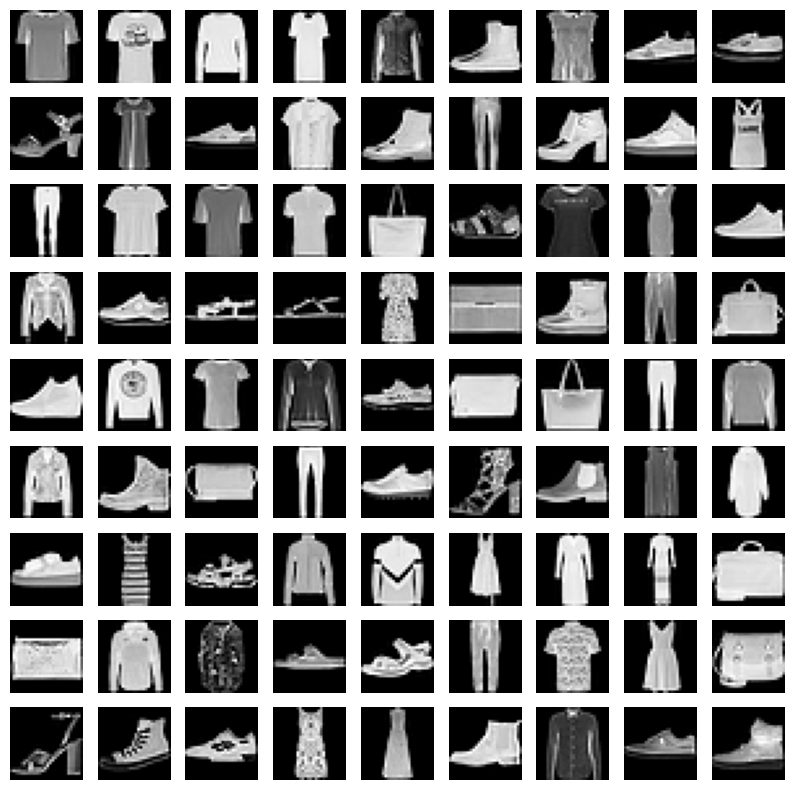

3/3 [==============================] - 0s 13ms/step


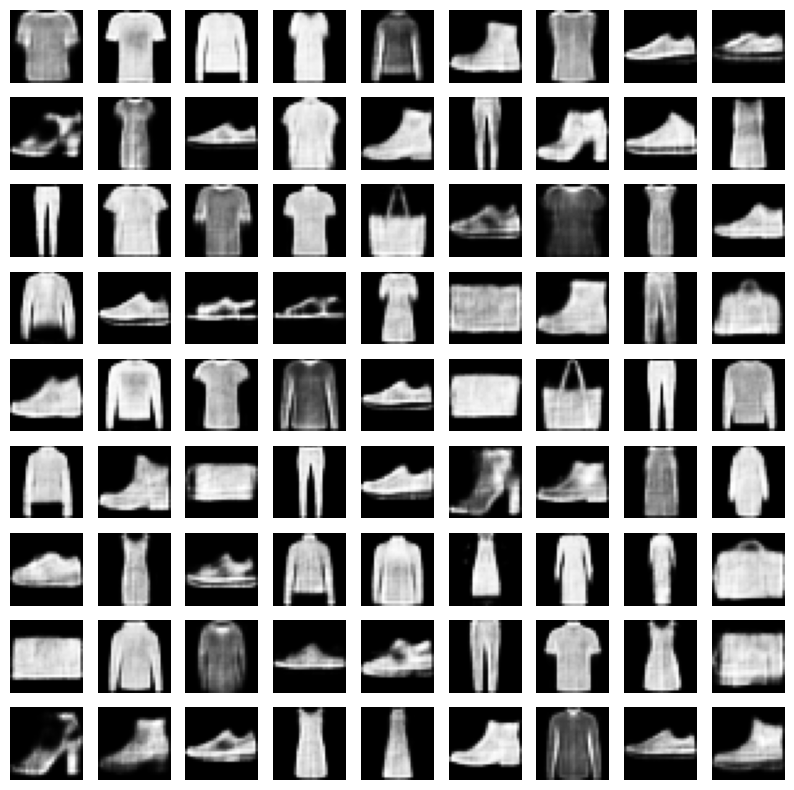

In [31]:
# Put the first 81 data points of val_x in 'val_x_sel'
"""Fill in your code here (~1 line)
"""
# YOUR CODE HERE
val_x_sel = val_x[:81]
plot_images(val_x_sel, dim_x=28, dim_y=28, fig_size=(10,10))

# Run the data points in 'val_x_sel' through the auto-encoder to obtain 'rec_val_x_sel'
"""Fill in your code here (~1 line)
"""
# YOUR CODE HERE
rec_val_x_sel = ae_model.predict(val_x_sel)

# Plot the reconstructed data
plot_images(rec_val_x_sel, dim_x=28, dim_y=28, fig_size=(10,10))

### Reconstructions should look pretty good but also a bit blurry.

In [32]:
""" [ASSERTS] Check 4b completed. """

assert var_exists('val_x_sel') and var_exists('rec_val_x_sel')


---
# [Task 5] \<*For CAI6108MLE Only*\> (25 points) AutoEncoder Latent Space

## In this task we will explore the latent space of the autocoder we have trained in Task 4.

### [Task 5a] (10 points) Exploring the latent space. Compute the average latent space representation of tops and bags using the validation data. Call these 'avg_latent_tops' and 'avg_latent_bags' respectively. Then fill in the provided code so it plots examples along the interpolation path.

In [33]:
def linear_exploration(source, target, num_steps):
    diff = target - source
    inc = diff / num_steps
    ret = np.zeros((num_steps, source.shape[0]))
    for i in range(0, num_steps):
        ret[i] = source + inc * i
    return ret

labels = ['Top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# first compute the average latent representation
"""Fill in your code here (~5-7 lines)
"""
# YOUR CODE HERE
raise NotImplementedError()

# Now let's compute and plot along the interpolation path. 
num_points = 81
expl = linear_exploration(avg_tops_latent, avg_bags_latent, num_points)
"""Fill in your code here (~1 lines). Store the results in 'expl_images'
"""
# YOUR CODE HERE
raise NotImplementedError()

plot_images(expl_images.reshape(-1, 28, 28), dim_x=28, dim_y=28, fig_size=(10,10))

NotImplementedError: 

In [ ]:
""" [ASSERTS] Check 5a completed. """

assert var_exists('avg_tops_latent') and var_exists('avg_bags_latent')
assert avg_tops_latent.shape == (latent_width,) or avg_tops_latent.shape == (latent_width,1)
assert avg_bags_latent.shape == (latent_width,) or avg_bags_latent.shape == (latent_width,1)

assert var_exists('expl_images')


### [Task 5b] (5 points) Complete the implementation of sample_new() that will sample new data points from the uniform [0,1] distribution over the latent space. You should *not* use any data (train_x/y, val_x/y, test_x/y, etc.). The provided code will then sample new images. How do they look?

In [ ]:
"""Fill in your code here (~1-2 lines)
"""
def sample_new(dec_model, count, latent_width=latent_width):
    ### sample 'count' new latent space points, decode them and return the result.
    # YOUR CODE HERE
    raise NotImplementedError()

# generate 81 new images
sample_images = sample_new(dec_model, 81, latent_width=latent_width)

# plot the produced images
plot_images(sample_images.reshape(-1, 28, 28), dim_x=28, dim_y=28, fig_size=(10,10))

### [Task 5c] (5 points) Do the images look like fashion-MNIST images? If not, explain why not.

In [ ]:
""" Remove the 'raise NotImplementedError' line(s). Write your answer as a comment in the place provided.  (Do not change the cell type from code to markdown.)"""
# 
## Answer: 
#
# YOUR CODE HERE
raise NotImplementedError()

### The following code will train the autoencoder again but this time with dropout=0.2.

In [ ]:
# Let's train the model
latent_width = 64
del ae_model, enc_model, dec_model
name, ae_model, enc_model, dec_model = create_simple_ae(latent_width=latent_width, dropout_rate=0.2, verbose=True)
    
max_epochs = 30
batch_size = 96

hist = ae_model.fit(train_x, train_x, epochs=max_epochs, batch_size=batch_size, validation_data=(val_x, val_x))

""" [ASSERTS] """
assert var_exists('hist')
val_mse = hist.history['val_mse']

assert val_mse[-1] >= 0.01

### We will now generate new images with the (newly trained) decoder.

In [ ]:
# generate 81 new images
sample_images = sample_new(dec_model, 81, latent_width=latent_width)

# plot the produced images
plot_images(sample_images.reshape(-1, 28, 28), dim_x=28, dim_y=28, fig_size=(10,10))

### [Task 5d] (5 points) Do these new images look more like fashion-MNIST images than before? If yes, explain why. Why does including dropout have this effect?

In [ ]:
""" Remove the 'raise NotImplementedError' line(s). Write your answer as a comment in the place provided.  (Do not change the cell type from code to markdown.)"""
# 
## Answer: 
#
# YOUR CODE HERE
raise NotImplementedError()